<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/06.04-Fitting-FOPTD-GEKKO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting FOPDT with GEKKO

This notebook shows how to use [`gekko`](https://gekko.readthedocs.io/en/latest/) to fit a FOPTD model from experimental data and it is very inspired in this [page](https://apmonitor.com/pdc/index.php/Main/FirstOrderOptimization).

In [2]:
!pip install gekko
import numpy as np
import pandas as pd
from gekko import GEKKO
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 59.8 MB/s eta 0:00:00


## Real data

First let's get some "real" data.

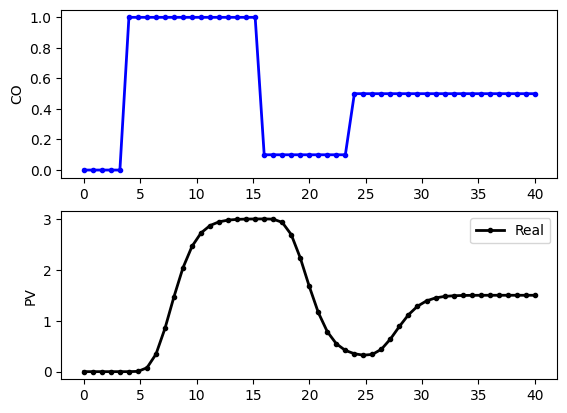

In [32]:
# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
url = 'http://apmonitor.com/pdc/uploads/Main/data_fopdt.txt'
data = pd.read_csv(url)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
y = data['y'].values

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,u,'b.-',lw=2)
plt.ylabel('CO')
plt.subplot(2,1,2)
plt.plot(t,y,'k.-',lw=2,label='Real')
plt.legend()
plt.ylabel('PV')
plt.show()

## FOPTD fit

Now let's fit our FOPDT parameters to the "real" data.

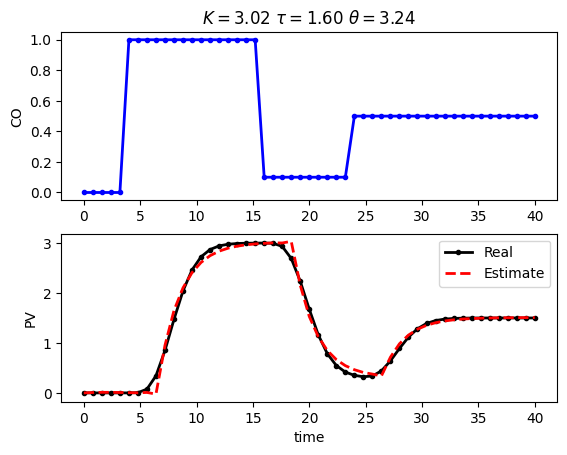

In [37]:
m = GEKKO(remote=False)
m.time = t; time = m.Var(0); m.Equation(time.dt()==1)

K = m.FV(2,lb=0,ub=10);      K.STATUS=1
tau = m.FV(3,lb=1,ub=200);  tau.STATUS=1
theta = m.FV(0,lb=0,ub=30); theta.STATUS=1

# add extrapolation points
td = np.concatenate((np.linspace(-theta.UPPER,min(t)-1e-5,5),t))
ud = np.concatenate((u[0]*np.ones(5),u))
# create cubic spline with t versus u
uc = m.Var(u); tc = m.Var(t); m.Equation(tc==time-theta)
m.cspline(tc,uc,td,ud,bound_x=False)

ym = m.Param(y); yp = m.Var(y)
m.Equation(tau*yp.dt()+(yp-y[0])==K*(uc-u[0]))

m.Minimize((yp-ym)**2)

m.options.IMODE=5
m.solve(disp=False)

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,u,'b.-',lw=2)
plt.ylabel('CO')
plt.title(f"$K={K.value[0]:.2f}$ $\\tau={tau.value[0]:.2f}$ $\\theta={theta.value[0]:.2f}$")
plt.subplot(2,1,2)
plt.plot(t,y,'k.-',lw=2,label='Real')
plt.plot(t,yp.value,'r--',lw=2,label='Estimate')
plt.ylabel('PV')
plt.xlabel('time')
plt.legend()
plt.show()